In [3]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd

In [4]:
# Setup plotting
plotting.setup_mpl()

# Enable the cache
ff1.Cache.enable_cache('./cache') 

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None

In [5]:
# Load the session data
race = ff1.get_session(2021, 'Russia', 'R')

# Get the laps
laps = race.load_laps(with_telemetry=True)

/opt/homebrew/lib/python3.9/site-packages/fastf1/core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Russian Grand Prix - Race [v2.3.0]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_status_data

In [6]:

# Calculate RaceLapNumber (LapNumber minus 1 since the warmup lap is included in LapNumber)
laps['RaceLapNumber'] = laps['LapNumber'] - 1

# Starting from lap 45 it started raining
laps = laps.loc[laps['RaceLapNumber'] >= 45]

In [7]:
# Get all drivers
drivers = pd.unique(laps['Driver'])

telemetry = pd.DataFrame()

# Telemetry can only be retrieved driver-by-driver
for driver in drivers:
    driver_laps = laps.pick_driver(driver)
    
    # Since we want to compare distances, we need to collect telemetry lap-by-lap to reset the distance
    for lap in driver_laps.iterlaps():
        driver_telemetry = lap[1].get_telemetry().add_distance()
        driver_telemetry['Driver'] = driver
        driver_telemetry['Lap'] = lap[1]['RaceLapNumber']
        driver_telemetry['Compound'] = lap[1]['Compound']
    
        telemetry = telemetry.append(driver_telemetry)

In [8]:
# Only keep required columns
telemetry = telemetry[['Lap', 'Distance', 'Compound', 'Speed', 'X','Y']]

# Everything that's not intermediate will be "slick"
telemetry['Compound'].loc[telemetry['Compound'] != 'INTERMEDIATE'] = 'SLICK'

In [9]:
# We want 25 mini-sectors
num_minisectors = 25

# What is the total distance of a lap?
total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

minisectors = [0]

for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

In [10]:
# Assign minisector to every row in the telemetry data
telemetry['Minisector'] =  telemetry['Distance'].apply(
  lambda z: (
    minisectors.index(
      min(minisectors, key=lambda x: abs(x-z)))+1
  )
)

In [11]:
# Calculate fastest tyre per mini sector
average_speed = telemetry.groupby(['Lap', 'Minisector', 'Compound'])['Speed'].mean().reset_index()


In [12]:
# Select the compound with the highest average speed
fastest_compounds = average_speed.loc[average_speed.groupby(['Lap', 'Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the Compound column
fastest_compounds = fastest_compounds[['Lap', 'Minisector', 'Compound']].rename(columns={'Compound': 'Fastest_compound'})


In [13]:
# Join the fastest compound per minisector with the full telemetry
telemetry = telemetry.merge(fastest_compounds, on=['Lap', 'Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Assign integer value to the compound because that's what matplotlib wants
telemetry.loc[telemetry['Fastest_compound'] == "INTERMEDIATE", 'Fastest_compound_int'] = 1
telemetry.loc[telemetry['Fastest_compound'] == "SLICK", 'Fastest_compound_int'] = 2

In [16]:
def generate_minisector_plot(lap, save=False, details=True):
    single_lap = telemetry.loc[telemetry['Lap'] == lap]

    x = np.array(single_lap['X'].values)
    y = np.array(single_lap['Y'].values)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    compound = single_lap['Fastest_compound_int'].to_numpy().astype(float)

    cmap = cm.get_cmap('ocean', 2)
    lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
    lc_comp.set_array(compound)
    lc_comp.set_linewidth(2)

    plt.rcParams['figure.figsize'] = [12, 5]
    
    if details:
        title = plt.suptitle(
            f"2021 Russian GP \n Lap {lap} - Slicks vs. Inters"
        )
        
    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    
    if details:
        cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1, 4))
        cbar.set_ticks(np.arange(1.5, 9.5))
        cbar.set_ticklabels(['Inters', 'Slicks'])
    
    if save:
        plt.savefig(f"output/minisectors_lap_{lap}.png", dpi=300)

    plt.show()

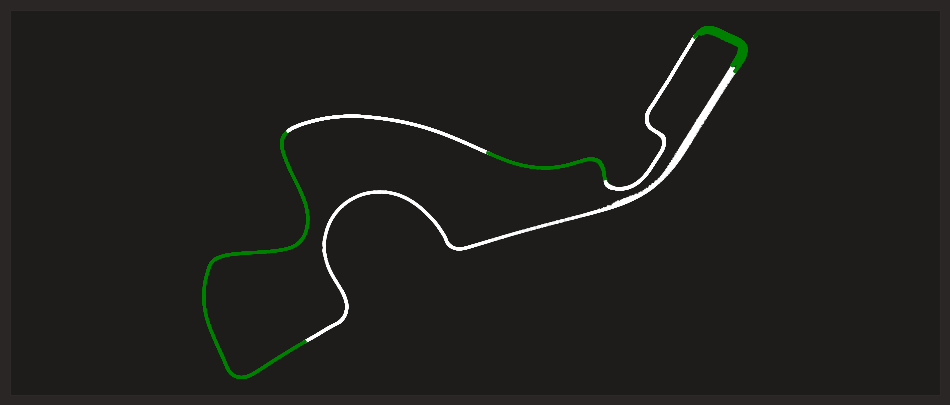

In [17]:
generate_minisector_plot(46, save=True, details=False)
